This file tries to optimize the parameters on Gradient Boosted Classifier

This one performs just as good as XGB, because they are basically the same thing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
"""
This cell gets the data ready to get passed into a pipeline
"""
#Import the Data set
df = pd.read_csv("data\\Traffic.csv")
df.dropna()

#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)


#This turns time into just minutes as a numeric
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]
X = X.drop(columns=['hour', 'minute'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [3]:
# Define features
numeric_features = ['Date', 'Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
categorical_features = ['Day of the week']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scalar", StandardScaler()) #We're gonna normalize the numeric data 
])

#This is for the catergorical features
categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")) #Shouldn't have to worry about unknowns 
])

#Put it into one preprosser
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define the full pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('gbc', GradientBoostingClassifier())
])

In [4]:
param_grid = {
    'gbc__n_estimators': [100, 200, 500], #Number of trees
    'gbc__learning_rate': [0.01, 0.1, 0.2], #Learning Rate
    'gbc__max_depth': [3, 5, 7], #The max depth of tree
    'gbc__subsample': [0.7, 1.0], #Fraction of data used per tree
    'gbc__max_features': ['sqrt', 'log2'] #Controls how many features to use per tree
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters for LR:", grid_search.best_params_)

y_pred_best = grid_search.best_estimator_.predict(X_test)
print(f"This is the accuracy score: {accuracy_score(y_test, y_pred_best):.4f}")

c:\Users\norma\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for LR: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__max_features': 'log2', 'gbc__n_estimators': 500, 'gbc__subsample': 1.0}
This is the accuracy score: 0.9954


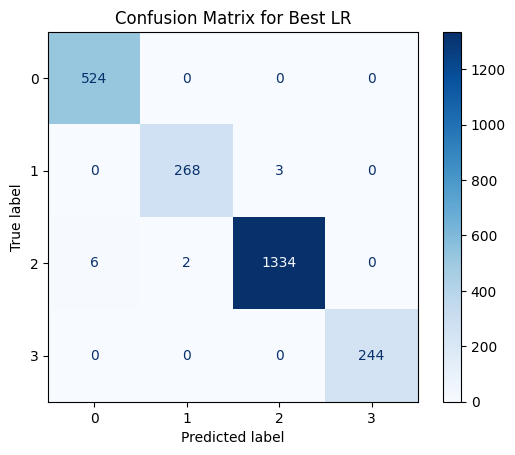

In [5]:
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap="Blues")  
plt.title("Confusion Matrix for Best LR")
plt.show()